# Modeling my SEC vs stock price data in PyCaret

Items I would like to explore:
- Pycaret has a bunch of "anomaly detection" that looks for things we've been talking about, like multicollinearity and outliers
    - does it give different results for the data I've been engineering vs the original dataset?
- What does a random forest suggest are important parameters?
- How, really, am I going to integrate the daybefore-dayof-dayafter price information?
- Does a model trained on "tech stock" data really generalize all that well to the rest of the market?
- Should I be trying to further transform my data to make it "suitable" for certain models, or looking for the model that suits my data instead?
    - have talked with mentor about log-transform and box-cox (which I need to look up), but I'm feeling some resistance to ideas like needing to 'remove' zero and/or negative data.
    - will scaling work where I have both numeric and categorical data? I do definitely have scale issues, and scaling might resolve some of the problems with the transforms that have been suggested.
- Note from clustering DataCamp: maybe try clustering stocks by price movement tendencies?

Reminders:
- Because this is stock data, it is at least somewhat time-based. Create holdout data set of recent-time data (might need 2 years or more to get ~20% of records) 
- test adfuller for stationarity; engineer for detrending if necessary
- start with other/simpler modeling and use Time Series Analysis if needed.
- fit some nonlinear/nonparametric models (RF, gradient boost)

### Try first: Throw the data at it and see what sticks

In [12]:
# I needed to install pycaret and scikitplot to get started here.
# for the first round, following beginner tutorial at 
# https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb
from pycaret.regression import *
import pandas as pd

df = pd.read_csv('tech_pctchg_ol100_ohe_for_ml.csv', parse_dates=['date'])
print(df.date.nunique()) #okay, can't use date for the index, I appear to have some duplicates.
print(df.shape)
print(df.date.max())
training = df[df['date']<'2018']
unseen = df[df['date']>='2018'] # this holds out ~20% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)
exp_regtutorial = setup(data = training,  target = 'close_plus1', session_id=123) # picking the day-after price, because pick something.

In [14]:
# something to tweak later: probably don't want to shuffle the data since it's time-oriented.
best_model = compare_models(exclude=['ransac'])

#### train and tune the top... 5 models, for some variety

In [15]:
br = create_model('br')

In [16]:
lr = create_model('lr')

In [17]:
et = create_model('et')

In [18]:
gbr = create_model('gbr')

In [19]:
rf = create_model('rf')

In [21]:
tuned_br = tune_model(br)
print(tuned_br)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=0.05, lambda_2=0.0001, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


In [22]:
tuned_lr = tune_model(lr)
print(tuned_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)


In [23]:
tuned_et = tune_model(et)
print(tuned_et)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0001,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=5, min_weight_fraction_leaf=0.0,
                    n_estimators=240, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


Okay, tuning made that model a lot worse...

In [24]:
tuned_gbr = tune_model(gbr)
print(tuned_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.129, loss='ls',
                          max_depth=8, max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.02, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=170,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=0.6, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


This one got worse also, although the ExtraTrees one beats it for dis-improvement.

In [25]:
tuned_rf = tune_model(rf)
print(tuned_rf)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


Not super impressed with auto-tuning! The only models that did better in tuning were nearly perfect (suspiciously perfect, perhaps) before I started. Keep an open mind, I'm just following a tutorial right now. Let's make some pictures!

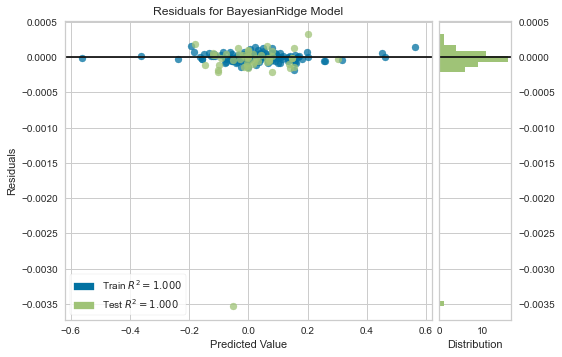

In [26]:
plot_model(tuned_br)

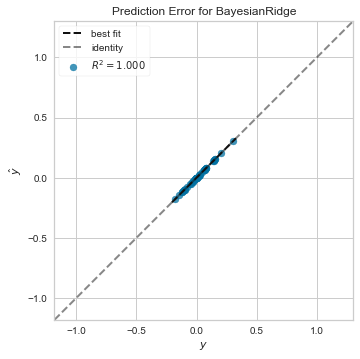

In [27]:
plot_model(tuned_br, plot='error')

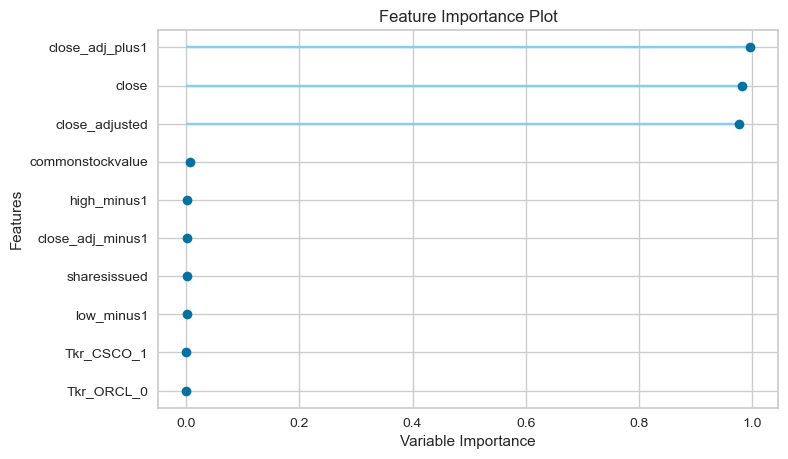

In [28]:
plot_model(tuned_br, plot='feature')

#### Already I'm betting that I need to separate out my price data and consider fewer price signals at once.
Let's see what some of the other models look like. I might pick the gbr and the rf model just to see what different model types are doing and what the (de)tuning did.

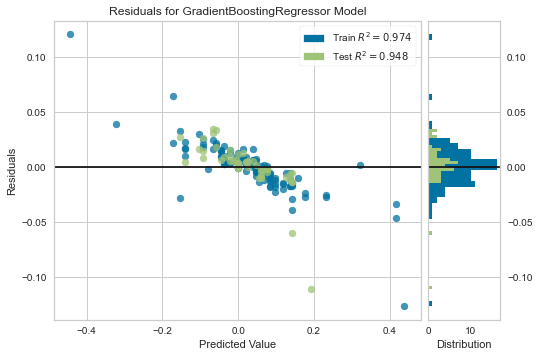

In [29]:
plot_model(tuned_gbr)

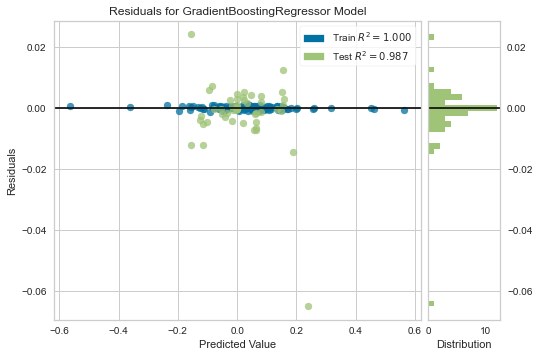

In [30]:
plot_model(gbr)

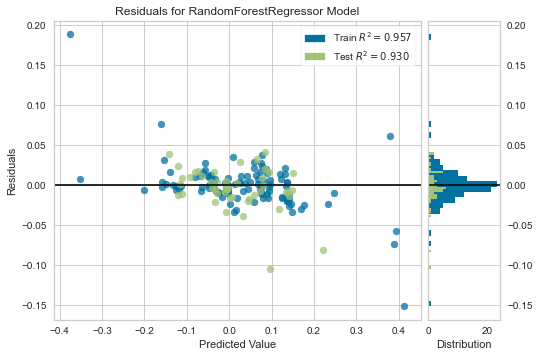

In [31]:
plot_model(tuned_rf)

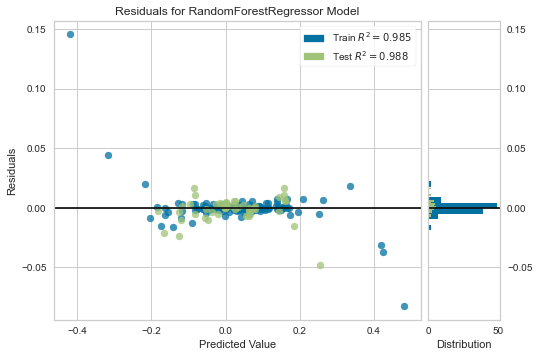

In [32]:
plot_model(rf)

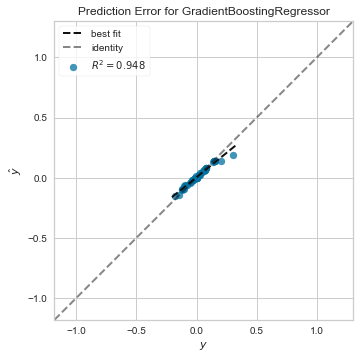

In [33]:
plot_model(tuned_gbr, plot='error')

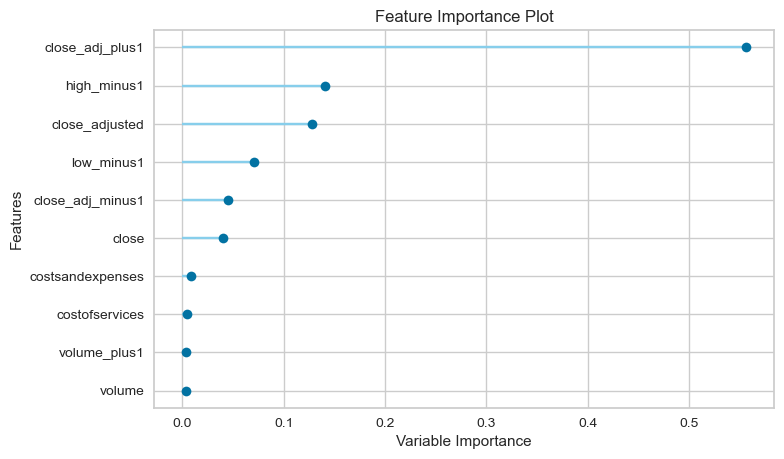

In [34]:
plot_model(tuned_gbr, plot='feature')

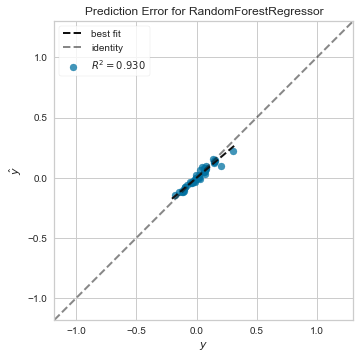

In [35]:
plot_model(tuned_rf, plot='error')

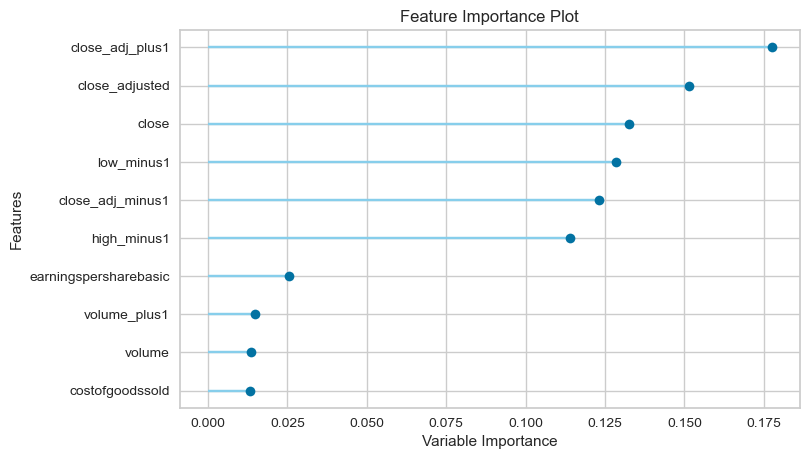

In [36]:
plot_model(tuned_rf, plot='feature')

Let's try the interactive evaluation. Not sure what this will produce if you're just reading through my work.

In [37]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'paramâ€¦

Yup, I'm seeing too many weird things in feature importances. Well, maybe not really weird that the "most important" features to the price I'm trying to predict are all the nearby prices. I saw in feature engineering how thoroughly correlated those are. A little more weird that the linear regression thinks the date components are important features. I think I want to go back and re-engineer the prices to produce an idea of how much they changed day-to-day, and get rid of the rest of the price signals.